In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
xs = np.random.uniform(low=0.0, high=500.0, size=1000)
ys = np.random.uniform(low=0.0, high=500.0, size=1000)

In [3]:
f1 = lambda x : 10000 / x
df1 = pd.DataFrame({'x' : xs, 'y' : ys})
df1['class'] = np.where(df1['y'] > f1(df1['x']), 1, 0)

f2 = lambda x : 200 * np.sin(0.05*x) + 250
df2 = pd.DataFrame({'x' : xs, 'y' : ys})
df2['class'] = np.where(df2['y'] > f2(df2['x']), 1, 0)

f3 = lambda x : np.power(x - 250, 2)/150 + 20
df3 = pd.DataFrame({'x' : xs, 'y' : ys})
df3['class'] = np.where(df3['y'] > f3(df3['x']), 1, 0)

f4 = lambda x, y: np.power(x - 250, 2) + np.power(y - 250, 2) <= np.power(105, 2)
df4 = pd.DataFrame({'x' : xs, 'y' : ys})
df4['class'] = np.where(f4(df4['x'], df4['y']), 1, 0)

datasets = [df1, df2, df3, df4]

In [4]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx.reshape(1,), X_pool[query_idx].reshape(1, -1)

In [5]:
def benchmark(learner, X_train, X_test, y_train, y_test, n_queries=100):
    
    scores = []

    for index in range(n_queries):

        query_index, query_instance = learner.query(X_train)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_train[query_index].reshape(1, -1), y_train[query_index].reshape(1, )
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        X_train, y_train = np.delete(X_train, query_index, axis=0), np.delete(y_train, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_test, y_test)
        
        scores.append(model_accuracy)
        
    return scores

In [6]:
uncertainty_scores = []
random_scores = []
entropy_scores = []

for df in datasets:
    
    X = df[['x', 'y']].to_numpy()
    y = df[['class']].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    uncertainty_learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling
    )

    random_learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=random_sampling
    )
    
    entropy_learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=entropy_sampling
    )
    

    u_score = benchmark(uncertainty_learner, X_train, X_test, y_train, y_test)
    r_score = benchmark(random_learner, X_train, X_test, y_train, y_test)
    e_score = benchmark(entropy_learner, X_train, X_test, y_train, y_test)
    
    uncertainty_scores.append(u_score)
    random_scores.append(r_score)
    entropy_scores.append(e_score)

In [18]:
plt.rcParams["figure.figsize"] = (7.5,5.5)

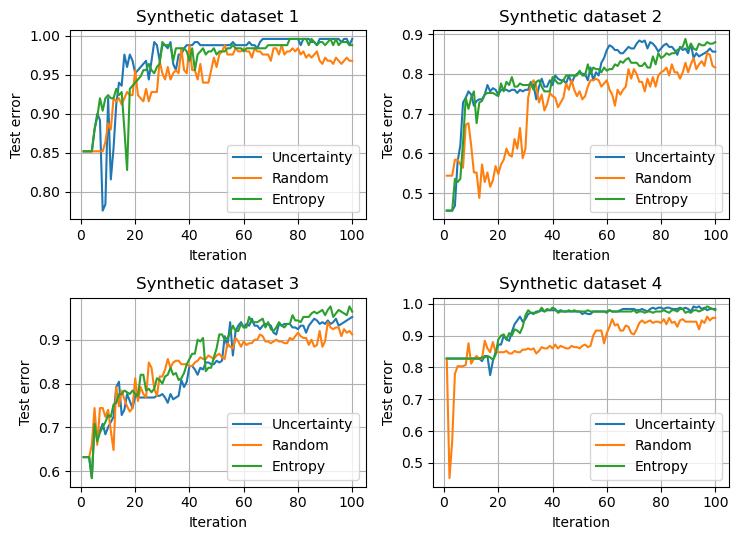

In [19]:
fig, axs = plt.subplots(2, 2)

xs = np.arange(1, 101)

axs[0,0].plot(xs, uncertainty_scores[0], label='Uncertainty')
axs[0,0].plot(xs, random_scores[0], label='Random')
axs[0,0].plot(xs, entropy_scores[0], label='Entropy')
axs[0,0].set_title('Synthetic dataset 1')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(xs, uncertainty_scores[1], label='Uncertainty')
axs[0,1].plot(xs, random_scores[1], label='Random')
axs[0,1].plot(xs, entropy_scores[1], label='Entropy')
axs[0,1].set_title('Synthetic dataset 2')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].plot(xs, uncertainty_scores[2], label='Uncertainty')
axs[1,0].plot(xs, random_scores[2], label='Random')
axs[1,0].plot(xs, entropy_scores[2], label='Entropy')
axs[1,0].set_title('Synthetic dataset 3')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(xs, uncertainty_scores[3], label='Uncertainty')
axs[1,1].plot(xs, random_scores[3], label='Random')
axs[1,1].plot(xs, entropy_scores[3], label='Entropy')
axs[1,1].set_title('Synthetic dataset 4')
axs[1,1].legend()
axs[1,1].grid()

for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Test error')

fig.tight_layout()



plt.show()